# Art_cls_CNN_Tset

In [1]:
import numpy as np
import pandas as pd

# 경고메세지 무시
import warnings
warnings.filterwarnings("ignore")

## 1. Data Introduce

In [2]:
# 데이터셋 압축 해제
import zipfile
import os

# Test Dataset
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Dataset/Art_Author_2/test.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

# Train Dataset
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Dataset/Art_Author_2/train.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

## 2. EDA

In [3]:
train_path = "/content/train"
test_path = "/content/test"

### 2.1 EDA 방법 1. 간단히 파일 이미지 개수 파악

In [4]:
def folder_info(data_path):
    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)

        if os.path.isdir(folder_path):
            image_count = len(os.listdir(folder_path))
            print(f"폴더명: {folder}, 이미지 개수: {image_count}")

In [5]:
folder_info(train_path)

폴더명: dog, 이미지 개수: 329
폴더명: elephant, 이미지 개수: 205
폴더명: giraffe, 이미지 개수: 235
폴더명: house, 이미지 개수: 245
폴더명: guitar, 이미지 개수: 134
폴더명: horse, 이미지 개수: 151
폴더명: person, 이미지 개수: 399


In [6]:
folder_info(test_path)

폴더명: 0, 이미지 개수: 350


### 2.2 EDA 방법 2. DF로 파일 이미지 개수 파악

In [7]:
def count_images(folder_path):
    author_counts = []

    # 폴더 이름
    for author_folder in os.listdir(folder_path):
        author_folder_path = os.path.join(folder_path, author_folder)

        # 폴더 별 이미지 수
        image_count = len([name for name in os.listdir(author_folder_path) if os.path.isfile(os.path.join(author_folder_path, name))])

        # 작가 이름, 이미지 수를 리스트에 저장
        author_counts.append({'작가': author_folder, '그림 수': image_count})

    # list -> df 변환
    author_counts_df = pd.DataFrame(author_counts)

    return author_counts_df

In [8]:
# 각 폴더에 있는 이미지 수 세기
count_images(train_path)

,작가,그림 수
0,dog,329
1,elephant,205
2,giraffe,235
3,house,245
4,guitar,134
5,horse,151
6,person,399


In [9]:
count_images(test_path)

,작가,그림 수
0,0,350


## 3. Data Splite_train/val

모델링에 앞서 Train 데이터셋을 8:2 비율로 Train/Valid 데이터셋으로 분할합니다.

In [10]:
import os
import shutil
from sklearn.model_selection import train_test_split

# train 폴더 명 raw_train 변환
os.rename("/content/train", "/content/raw_train")
dataset_folder = './raw_train'

# 해당 경로 raw_train 훈련/검증 셋 분할 예정
train_folder = './train'
val_folder =  './valid'

In [11]:
# 폴더 명(클래스) list 생성
# 아래 폴더로 구분 ['horse', 'giraffe', 'person', 'house', 'guitar', 'dog', 'elephant']
class_folders = [folder for folder in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, folder))]

# 각 클래스로 데이터 이동
for class_folder in class_folders:
    class_folder_path = os.path.join(dataset_folder, class_folder)

    # 클래스 폴더 안의 파일 목록 가져오기
    file_list = os.listdir(class_folder_path)

    # 훈련 / 검증 데이터 나누기
    train_files, val_files = train_test_split(file_list, test_size=0.2, random_state=2024)

    # 훈련 데이터를 train 폴더로 이동
    for file_name in train_files:
        src = os.path.join(class_folder_path, file_name)
        dst = os.path.join(train_folder, class_folder, file_name)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)

    # 검증 데이터를 val 폴더로 이동
    for file_name in val_files:
        src = os.path.join(class_folder_path, file_name)
        dst = os.path.join(val_folder, class_folder, file_name)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)

## 4. Image Setting

In [12]:
import torch
from torchvision import transforms, datasets
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# 데이터셋 경로
train_dir = './train'
val_dir = './valid'

# 이미지 전처리 / 정규화
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Dataset = 227x227 구성
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 이미지를 정규화
])

# ImageFolder => 학습 데이터셋 불러오기
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)

# 데이터 로드
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2) # num workes defult = 2~4
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

# 클래스 수
num_classes = len(train_dataset.classes)
print("폴더(class)) 수:", num_classes)

# trainset과 valset의 샘플 수 출력
print("trainset 샘플 수:", len(train_dataset))
print("valset 샐플 수:", len(val_dataset))

폴더(class)) 수: 7
trainset 샘플 수: 1357
valset 샐플 수: 341


## 5. 신경망 Setting

In [13]:
# 신경망(CNN) 정의

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)  # 수정된 출력 크기에 맞춰줍니다. 즉, 사이즈에 맞춰 이미지 조정
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)  # 클래스 수에 맞게 출력 크기를 조정

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)  # 수정된 출력 크기에 맞춰줍니다.
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## 6. Model Training

In [14]:
# 손실함수(criterion) = CrossEntropyLoss
# 옵티마이저(optimizer) = SGD
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10

# 손실 및 정확도를 저장할 리스트 생성 및 초기화
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# 모델 학습
for epoch in range(num_epochs):
    # 학습 모드 활성화
    net.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # 미니배치 단위로 학습 데이터를 로드하고 모델을 학습합니다.
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # 경사 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        # 통계
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # 학습데이터 손실과 정확도 기록
    train_loss = running_train_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # 검증 모드 활성화
    net.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    # 검증 데이터에 대해 평가
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # 검증 손실과 정확도 기록
    val_loss = running_val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # 에폭마다 결과 출력
    print(f'epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')

print('Finished Training')

# 신경망 저장
PATH = './dataset_custom_net.pth'
torch.save(net.state_dict(), PATH)

epoch [1/10], Train Loss: 1.8387, Train Accuracy: 25.64%, Val Loss: 1.8313, Val Accuracy: 28.74%
epoch [2/10], Train Loss: 1.7256, Train Accuracy: 35.45%, Val Loss: 1.7503, Val Accuracy: 32.55%
epoch [3/10], Train Loss: 1.6490, Train Accuracy: 39.50%, Val Loss: 1.7371, Val Accuracy: 31.96%
epoch [4/10], Train Loss: 1.5429, Train Accuracy: 43.48%, Val Loss: 1.7203, Val Accuracy: 31.96%
epoch [5/10], Train Loss: 1.3993, Train Accuracy: 49.08%, Val Loss: 1.9684, Val Accuracy: 29.33%
epoch [6/10], Train Loss: 1.2634, Train Accuracy: 53.21%, Val Loss: 1.7501, Val Accuracy: 34.60%
epoch [7/10], Train Loss: 1.0058, Train Accuracy: 65.88%, Val Loss: 2.0838, Val Accuracy: 36.07%
epoch [8/10], Train Loss: 0.7250, Train Accuracy: 73.91%, Val Loss: 2.0153, Val Accuracy: 38.71%
epoch [9/10], Train Loss: 0.4063, Train Accuracy: 85.78%, Val Loss: 3.7584, Val Accuracy: 35.19%
epoch [10/10], Train Loss: 0.2531, Train Accuracy: 92.48%, Val Loss: 3.2782, Val Accuracy: 35.48%
Finished Training


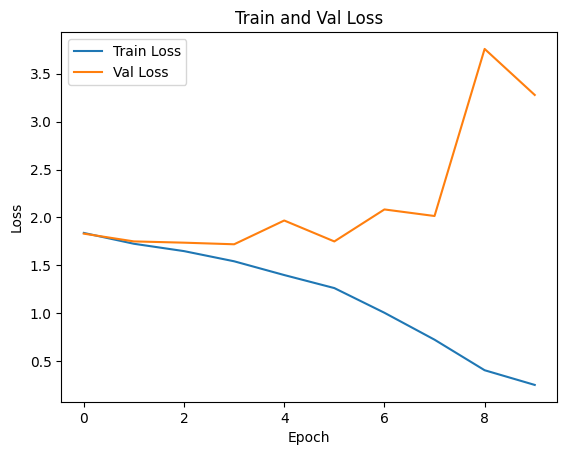

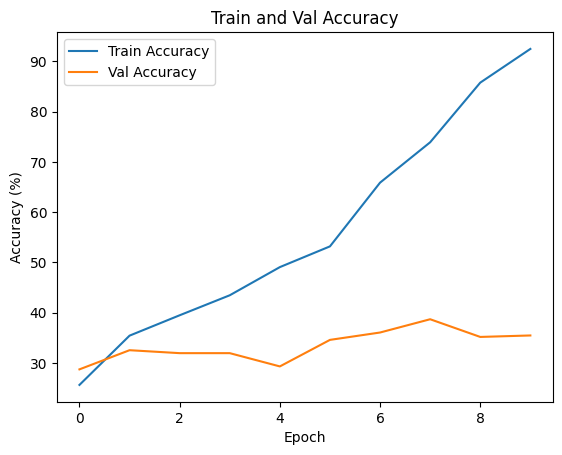

In [15]:
import matplotlib.pyplot as plt

# 손실(Loss) 그래프를 출력
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Val Loss')
plt.legend()
plt.show()

# 정확도(ACC) 그래프를 출력
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Val Accuracy')
plt.legend()
plt.show()

**[학습 결과]**

1. 전반적으로 ACC, Loss 모두 Train 학습결과는 개선되나 Val 데이터에서 지속 성능이 저하되고 있습니다.
2. 이는 전반적인 학습이 잘 이루어지지 않은 것으로 판단하여 추가적인 전처리를 진행하여 다시 학습을 진행합니다.

## 7. Overfitting preprocessing

In [16]:
# ./test' =>  '.ipynb_checkpoints' 폴더를 삭제
# 이전 저장된 상태로 복원하는 절차입니다.

checkpoint_path = os.path.join('./test', '.ipynb_checkpoints')
if os.path.exists(checkpoint_path):
    os.rmdir(checkpoint_path)

### 7.1 Solution 1_데이터 정규화

Test 데이터셋 정규화를 위해 이전 설정하였던 transform에서 transeform_nor 변수로 재정의합니다.

In [34]:
test_transform = transforms.Compose([
    transforms.Resize((227, 227)),  # 이미지 크기를 조절합니다.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 이미지를 정규화합니다.
])

# 테스트 데이터셋을 불러옵니다. (필요에 따라 변환을 적용할 수 있습니다.)
test_dataset = datasets.ImageFolder(root='./test', transform=test_transform)

# 데이터 로더 설정
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

In [35]:
# 클래스 이름과 해당 정수 라벨을 포함하는 리스트를 생성합니다.
classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
label_indices = list(range(len(classes)))

label_indices

[0, 1, 2, 3, 4, 5, 6]

## 8. 모델 평가

In [36]:
# 모델 평가

correct = 0
total = 0
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.tolist())  # 예측된 레이블을 리스트에 추가

print('Test_Accuracy: %d %%' % (100 * correct / total))

# 각 이미지 파일에 대한 예측을 출력합니다.
for i, img_name in enumerate(test_dataset.imgs):
    print('Image %s predicted as %s (%d)' % (img_name[0], classes[predicted_labels[i]], predicted_labels[i]))

Test_Accuracy: 26 %
Image ./test/0/0001.jpg predicted as person (6)
Image ./test/0/0002.jpg predicted as house (5)
Image ./test/0/0003.jpg predicted as person (6)
Image ./test/0/0004.jpg predicted as dog (0)
Image ./test/0/0005.jpg predicted as person (6)
Image ./test/0/0006.jpg predicted as house (5)
Image ./test/0/0007.jpg predicted as house (5)
Image ./test/0/0008.jpg predicted as elephant (1)
Image ./test/0/0009.jpg predicted as giraffe (2)
Image ./test/0/0010.jpg predicted as elephant (1)
Image ./test/0/0011.jpg predicted as house (5)
Image ./test/0/0012.jpg predicted as house (5)
Image ./test/0/0013.jpg predicted as horse (4)
Image ./test/0/0014.jpg predicted as giraffe (2)
Image ./test/0/0015.jpg predicted as dog (0)
Image ./test/0/0016.jpg predicted as person (6)
Image ./test/0/0017.jpg predicted as giraffe (2)
Image ./test/0/0018.jpg predicted as horse (4)
Image ./test/0/0019.jpg predicted as house (5)
Image ./test/0/0020.jpg predicted as horse (4)
Image ./test/0/0021.jpg pred